## Imports

#### Installing necessary libraries

In [1]:
# pip install pandas openpyxl simplified_scrapy matplotlib seaborn sklearn

#### Importing neccessary libraries

In [2]:
import pandas as pd
import numpy as np
import os
from openpyxl import Workbook
from simplified_scrapy import SimplifiedDoc, utils
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor

pd.set_option('display.float_format', '{:.2f}'.format)

## Morningstar dataset conversion to Excel file (.xlsx)

#### Converting datasets from .csv to .xlsx format to be imported by Pandas

In [3]:
# Func to open files in /datasets/ folder
def open_files():
    files = []
    for i in os.walk('./datasets'):
        files= i[2]

    return files

# Read files as XML    
def readFile(filename):
    xml = utils.getFileContent(filename)
    doc = SimplifiedDoc(xml)
    tables = doc.selects('Worksheet').selects('Row').selects('Cell').text # Get all data
    sheetNames = doc.selects('Worksheet>ss:Name()') # Get sheet name
    return sheetNames,tables,filename.split('/')[2].split('.')[0]

# Create Excel workbook from file
def to_Excel(sheetNames,tables, filename):
    wb = Workbook() # Create Workbook
    for i in range(len(sheetNames)):
        worksheet = wb.create_sheet(sheetNames[i]) # Create sheet
        for row in tables[i]:
            worksheet.append(row)
    print('./datasets_excel/'+ filename + '.xlsx')
    wb.save('./datasets_excel/'+ filename + '.xlsx') # Save file

In [4]:
# Rename files to .xml file (because the .csv files from morningstar are actually formatted as XML)
def rename_files():
    for filename in (os.listdir("./datasets")):
        name = filename.split('.')[0]
        print(name)
        
        dst = name + ".xml"
        src ='./datasets/'+ filename
        dst ='./datasets/'+ dst
          
        # rename() function will
        # rename all the files
        os.rename(src, dst)
        
# Convert files from .xml to .xlsx
def convert_files():    
    files = open_files()
    rename_files()

    for file in files:
        to_Excel(*readFile("./datasets/" + file))

In [5]:
#convert_files()

## Import datasets into Pandas dataframes

#### Importing all workbooks (with multiple worksheets) into the datasets_excel file. Each workbook corresponds to a company.

In [6]:
files = []
for i in os.walk('./datasets_excel/'):
    files=i[2]
    
files = sorted(files)

workbooks = {}
for file in files:
    workbooks[file.split('.')[0]] = pd.read_excel('./datasets_excel/' + file, sheet_name=None)

## Cleaning

### Normalising statement items (WIP)

#### Creating an easy naming scheme to use across the notebook.

In [7]:
statement_items = defaultdict(set)

for company in workbooks:
    for sheet in workbooks[company]:
        if sheet != 'Sheet' and 'Item' in workbooks[company][sheet]:
            statement_items[sheet].update(workbooks[company][sheet]['Item'])

### Restructuring datasets and creating combined HY and FY dataset

#### Creating a combined workbook with half yearly and full yearly data all in one while detecting any missing sheets or duplicates.

In [8]:
workbooks_combined = defaultdict(dict)
workbooks_keys = list(workbooks.keys())

for i in range(len(workbooks)//2):
    for sheet in statement_items:
        workbook_FY = workbooks[workbooks_keys[i*2]] # Reading in the full-yearly statements
        workbook_HY = workbooks[workbooks_keys[i*2 + 1]] # Reading in the half-yearly statements
        new_sheet = _ 
        
        if sheet in workbook_FY and sheet in workbook_HY:
            sheet_FY = workbook_FY[sheet].drop(['ASX Code', 'Company Name'], axis=1)
            sheet_HY = workbook_HY[sheet].drop(['ASX Code', 'Company Name'], axis=1)

            new_sheet = pd.concat([sheet_FY, sheet_HY], axis=1, join='inner')
            new_sheet = new_sheet.loc[:,~new_sheet.columns.duplicated()] # Drop extra 'item' 
            new_sheet = new_sheet.set_index(['Item'])
            
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_combined[workbooks_keys[i*2].split('_')[0]][sheet] = new_sheet.transpose()    
        else:
            print("Missing tab:", workbooks_keys[i*2], sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis


#### Constructing a seperated workbook such that each company's half-yearly and yearly data is cleaned and collated separately.

In [9]:
workbooks_separated = defaultdict(lambda: defaultdict(dict))
workbooks_keys = list(workbooks.keys())

for workbook in workbooks:
    for sheet in statement_items:       
        if sheet in workbooks[workbook]:
            new_sheet = workbooks[workbook][sheet].drop(['ASX Code', 'Company Name'], axis=1)
            
            new_sheet = new_sheet.set_index(['Item'])
            new_sheet.columns = pd.to_datetime(new_sheet.columns, format='%m/%y')
            new_sheet = new_sheet.sort_index(axis=1)
            
            new_sheet = new_sheet.replace('--', 0, regex=True)
            new_sheet = new_sheet.astype('float')

            workbooks_separated[workbook.split('_')[0]][workbook.split('_')[1]][sheet] = new_sheet.transpose()
        else:
            print("Missing tab:", workbook, sheet)            

Missing tab: ANZ_FY Sundry Analysis
Missing tab: ANZ_HY Sundry Analysis
Missing tab: CBA_FY Sundry Analysis
Missing tab: CBA_HY Sundry Analysis
Missing tab: NAB_FY Sundry Analysis
Missing tab: NAB_HY Sundry Analysis
Missing tab: WBC_FY Sundry Analysis
Missing tab: WBC_HY Sundry Analysis


### Identifying correlated features

#### Show the correlation matrix for the items that appear in ADH's full yearly income statement.

In [10]:
plt.figure(figsize=(10, 10))
cm = workbooks_separated['ADH']['FY']['Profit Loss'].corr().abs()
cm.head()

Item,Operating Revenue,Other Revenue,Total Revenue Excluding Interest,Operating Expenses,EBITDA,Depreciation,Amortisation,Depreciation and Amortisation,EBIT,Interest Revenue,...,Net Profit after Tax Before Abnormals,Abnormals,Abnormals Tax,Net Abnormals,Reported NPAT After Abnormals,Outside Equity Interests,Shares Outstanding at Period End,Weighted Average Number of Shares,EPS Adjusted (cents/share),EPS After Abnormals (cents/share)
Item,,,,,,,,,,,,,,,,,,,,,
Operating Revenue,1.00,0.29,1.00,0.98,0.90,0.76,0.87,0.78,0.93,0.10,...,0.91,0.67,NaN,0.67,0.90,NaN,0.67,0.82,0.92,0.91
Other Revenue,0.29,1.00,0.29,0.34,0.14,0.05,0.17,0.05,0.18,0.14,...,0.18,0.01,NaN,0.01,0.19,NaN,0.01,0.52,0.20,0.20
Total Revenue Excluding Interest,1.00,0.29,1.00,0.98,0.90,0.76,0.87,0.78,0.93,0.10,...,0.91,0.67,NaN,0.67,0.90,NaN,0.67,0.82,0.92,0.91
Operating Expenses,0.98,0.34,0.98,1.00,0.80,0.63,0.91,0.65,0.85,0.03,...,0.83,0.53,NaN,0.53,0.83,NaN,0.53,0.90,0.84,0.84
EBITDA,0.90,0.14,0.90,0.80,1.00,0.94,0.66,0.95,0.98,0.24,...,0.96,0.88,NaN,0.88,0.94,NaN,0.89,0.54,0.96,0.93


<Figure size 720x720 with 0 Axes>

#### Show the pairs of features who have a correlation greater than 0.999

In [11]:
cm_sort = cm.unstack()
cm_sort = cm_sort.sort_values(kind="quicksort", ascending=False)

cm_sort = cm_sort[cm_sort > 0.999]

cm_sort.head()

correls = []

for multidx in cm_sort.index:
    if multidx[0] != multidx[1]:
        correls.append([multidx[0], multidx[1], cm_sort[multidx[0]][multidx[1]]])
        
correls = pd.DataFrame(correls, columns = ['Variable 1', 'Variable 2', 'Correlation'])
correls

,Variable 1,Variable 2,Correlation
0,Abnormals,Net Abnormals,1.00
1,Net Abnormals,Abnormals,1.00
2,Operating Revenue,Total Revenue Excluding Interest,1.00
3,Total Revenue Excluding Interest,Operating Revenue,1.00
4,Net Interest Expense,Interest Expense,1.00
5,Interest Expense,Net Interest Expense,1.00
6,Depreciation,Depreciation and Amortisation,1.00
7,Depreciation and Amortisation,Depreciation,1.00
8,Net Profit after Tax Before Abnormals,PreTax Profit,1.00
9,PreTax Profit,Net Profit after Tax Before Abnormals,1.00


## Visualisation and Investigation into Datasets

#### Line graph based on the operating revenue in the Profit Loss worksheet for companies across both half and full yearly datasets.

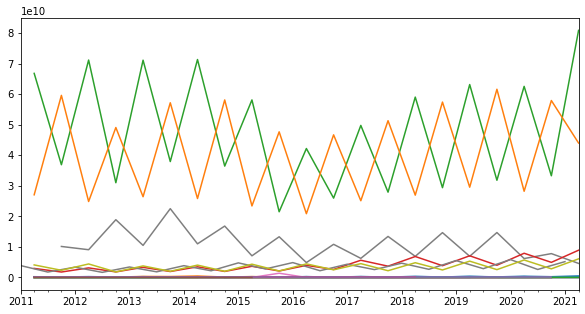

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

for workbook in workbooks_combined:
    if 'Operating Revenue' in workbooks_combined[workbook]['Profit Loss']:
        workbooks_combined[workbook]['Profit Loss']['Operating Revenue'].plot()


#### Histogram based on the operating revenue in the Profit Loss worksheet for companies across both half and full yearly datasets.

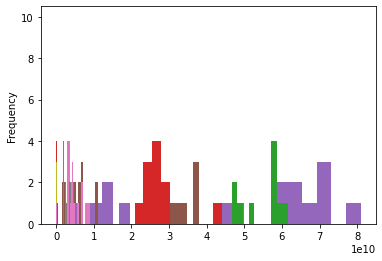

In [13]:
fig, ax = plt.subplots()

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
         if 'Operating Revenue' in workbooks_separated[workbook][period]['Profit Loss']:
                workbooks_separated[workbook][period]['Profit Loss']['Operating Revenue'].plot.hist()
   


#### This example is based specifically on the ADH (Adairs Ltd), half yearly and full yearly financial statement. It looks at the Ratio Analysis worksheet in the dataset, as this will later be used to create further models. The Ratio Analysis worksheet is essential when calculating the Beneish M-Score. The line plot above indicates various years of growths and drops which will be further investigated using Beneish M-Score statistical model.

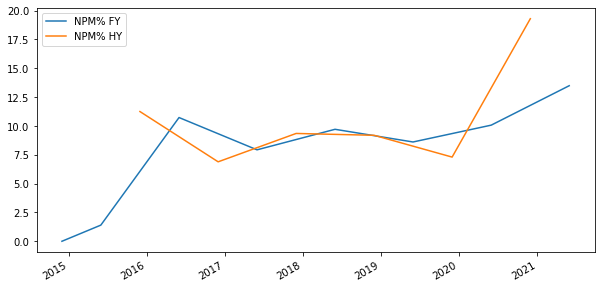

In [14]:
npm1 = pd.DataFrame(workbooks_separated['ADH']['FY']['Ratio Analysis']['Net Profit Margin (%)'])
npm2 = pd.DataFrame(workbooks_separated['ADH']['HY']['Ratio Analysis']['Net Profit Margin (%)'])

npm1.columns = ['NPM% FY']
npm2.columns = ['NPM% HY']

fig, ax = plt.subplots(figsize=(10, 5))
npm1.plot(ax=ax)
npm2.plot(ax=ax)
ax.legend()


## Beneish M-Score

### 1. DSRI

#### The function calc_DSRI is used to calculate the Days Sales in Receivables Index using the array days_receivables to calculate the ratio of days sales in receivables for a particular period(t1) by the previous period(t0) in the specified worksheet.

In [15]:
def calc_DSRI(company):
    res = {}
    days_receivables = []
    if 'Days Receivables' in company['Ratio Analysis']:
        days_receivables = company['Ratio Analysis']['Days Receivables']
    
    for row in range(0, len(days_receivables)):
        t1 = days_receivables.iloc[row]
        t0 = days_receivables.iloc[row-1] if (row-1 >= 0) else np.nan
        res[days_receivables.index[row]] = t1/t0
        
    return pd.Series(res)

#### The example used here is for ADH Half yearly dataset. The line plot indicates a drop in days receivables in 2018 followed by a drastic increase in 2019 which means there is a possibilty of revenue manipulation.

<AxesSubplot:>

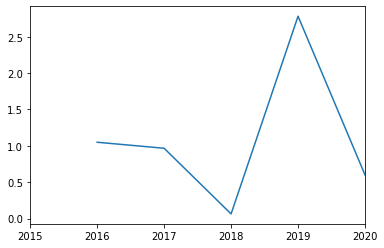

In [16]:
calc_DSRI(workbooks_separated['ADH']['HY']).plot()

### 2. GMI

#### The net profit margin was used instead of the the Gross Margin for the calculation of Gross Margin  Index which is found on the Ratio Analysis worksheet. It is calculated by dividing the prior period gross margin(t0) by current period gross margin(t1).

In [17]:
def calc_GMI(company):
    res = {}
    profit_margin = []
    if 'Net Profit Margin (%)' in company['Ratio Analysis']:
        profit_margin = company['Ratio Analysis']['Net Profit Margin (%)']
    
    for row in range(0, len(profit_margin)):
        t1 = profit_margin.iloc[row]
        t0 = profit_margin.iloc[row-1] if (row-1 >= 0) else np.nan
        res[profit_margin.index[row]] = t0/t1
        
    return pd.Series(res)

#### The company used here is ADH and its full yearly data. The line plot shows that there was a drastic increase in the net profit in 2017 followed by a flucatiion in the index, which could indicate a deep look into the profits might be necessary to get a better understanding of the company's financial situation.

<AxesSubplot:>

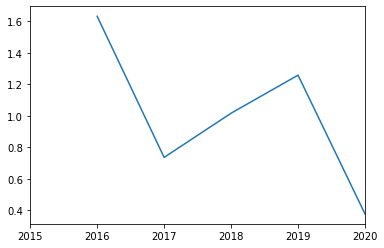

In [18]:
calc_GMI(workbooks_separated['ADH']['HY']).plot()

### 3. AQI

#### The Asset Quality Index is calcualted using the non-current assets, PP&E and total assets which are found on the 'Balance Sheet' worksheet in the dataset. The Asset Quality(aq) Index requires the Asset Quality to be calculated using the formula(Total Assets - (Current Assets +PP&E)/ Total Assets) and the new AQ(aq1) is divided by prior AQ (aq0).

In [19]:
def calc_AQI(company):
    res = {}
    bs = company['Balance Sheet']
    
    for row in range(0, len(bs)):
        if 'NCA - PP&E' not in bs or 'Total Current Assets' not in bs or 'Total Assets' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        if row - 1 < 0:
            res[bs.index[row]] = np.nan
            continue
            
        t1 = bs.iloc[row]
        t0 = bs.iloc[row-1]
        
        aq1 = t1['Total Assets'] - (t1['Total Current Assets']+ t1['NCA - PP&E'])
        aq1 = aq1 / t1['Total Assets']
        
        aq0 = t0['Total Assets'] - (t0['Total Current Assets']+ t0['NCA - PP&E'])
        aq0 = aq0 / t0['Total Assets']
                
        res[bs.index[row]] = aq1/aq0
        
    return pd.Series(res)

#### The line plot above is used for ADH full year and there seems to be a rise in the year 2017 and drop in the year 2021. This index could suggest any excessive capitalization of costs within the company for a particular period in the financial statement.

<AxesSubplot:>

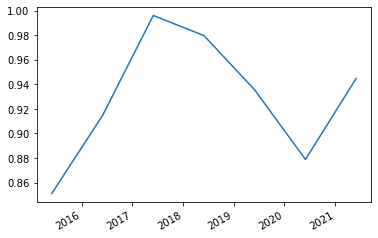

In [20]:
calc_AQI(workbooks_separated['ADH']['FY']).plot()

### 4. SGI

#### Sales Growth Index is computed using the company's sales(revenue) for the current period(t1) by the sales(revenue) of the previous period(t0). The feature used to calculate the SGI is 'Total Revenue Excluding Interest' from the 'Profit Loss' worksheet.

In [21]:
def calc_SGI(company):
    res = {}
    totrev = []
    if 'Total Revenue Excluding Interest' in company['Profit Loss']:
        totrev = company['Profit Loss']['Total Revenue Excluding Interest']
   
    for row in range(0, len(totrev)):
        t1 = totrev.iloc[row]
        t0 = totrev.iloc[row-1] if (row-1 >= 0) else np.nan
        res[totrev.index[row]] = t0/t1
    
    return pd.Series(res)

#### The line plot for ADH full yearly SGI calculation indicates that there are drastic changes in between each period which could suggest that there is some manipulation trying to meet earnings targets or high capital needs and needs to be closely monitored.

<AxesSubplot:>

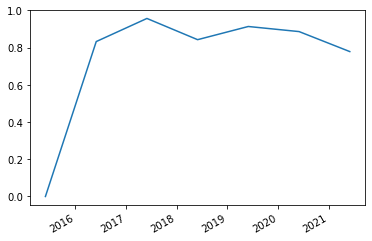

In [22]:
calc_SGI(workbooks_separated['ADH']['FY']).plot()

### 5. DEPI

#### The Depreciation Index represents the ratio of depreciation of the current period(dep1) from the previous period(dep0). To find the depreciation rate, the data for ‘Depreciation’ from the ‘Profit Loss’ sheet and ‘PP&E’ from the ‘BalanceSheet’ is used. 

Depreciation Rate = Depreciation/ (Depreciation + PP&E) 

In [23]:
def calc_DEPI(company):
    res = {}
    bs = company['Balance Sheet']
    inc = company['Profit Loss']
    
    for row in range(0, len(bs)):
        if 'Depreciation' not in inc or 'NCA - PP&E' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        if row - 1 < 0:
            res[bs.index[row]] = np.nan
            continue 
        
        bs1 = bs.iloc[row]
        bs0 = bs.iloc[row-1]
        
        inc1 = inc.iloc[row]
        inc0 = inc.iloc[row-1]
        
        dep1 = inc1['Depreciation']
        dep1 = dep1 / (inc1['Depreciation'] + bs1['NCA - PP&E'])
        
        dep0 = inc0['Depreciation']
        dep0 = dep0 / (inc0['Depreciation'] + bs0['NCA - PP&E'])
        
        res[bs.index[row]] = dep0/dep1
        
    return pd.Series(res)

#### In this line plot for ADH full yearly data, the ratio being greater than 1 indicates that the depreciation rate has lowered which could reflect the increase in income due to policy changes or adopting new methods within that period.

<AxesSubplot:>

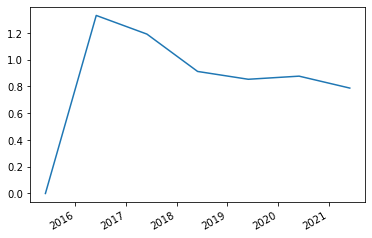

In [24]:
calc_DEPI(workbooks_separated['ADH']['FY']).plot()

### 6. SGAI

#### The Sales, General & Administrative Expenses Index is measured using the ratio of SGA expenses for the current period(sga1) over the prior(sga2). The ‘Profit Loss’ sheet from the financial statement of each company was used to select the ‘Operating Expense’ and ‘Total Revenue Excluding Interest’.

In [25]:
def calc_SGAI(company):
    res = {}
    inc = company['Profit Loss']
    
    for row in range(0, len(inc)):
        if 'Total Revenue Excluding Interest' not in inc or 'Operating Expenses' not in inc:
            res[inc.index[row]] = np.nan
            continue
            
        if row - 1 < 0:
            res[inc.index[row]] = np.nan
            continue 
            
        t1 = inc.iloc[row]
        t0 = inc.iloc[row-1]
        
        sga1 = t1['Operating Expenses']
        sga1 = sga1 / t1['Total Revenue Excluding Interest']
        
        sga0 = t0['Operating Expenses']
        sga0 = sga0 / t0['Total Revenue Excluding Interest']
        
        res[inc.index[row]] = sga1/sga0
       
    return pd.Series(res)

#### When the efficiency of SGAI decreases, it could make companies predisposed to manipulating earnings, this can be seen in ADH full year statement in the year 2020.

<ipython-input-25-074f2654ca65>:21: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']


<AxesSubplot:>

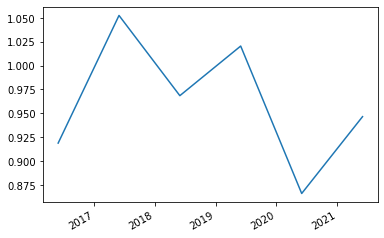

In [26]:
calc_SGAI(workbooks_separated['ADH']['FY']).plot()

### 7. TATA

#### Total Accruals to Total Assets focuses on the cash flow of the company against the total assets. There are a new sheets that are necessary to calculate the TATA, from the ‘Profit Loss’ sheet ‘PreTax Profit’, from ‘Cash Flow’ sheet ‘Net Operating Cashflows’ and ‘Net Investing Cashflows’ and finally ‘Total Assets’ from ‘Balance Sheet’.

The following formula is used.
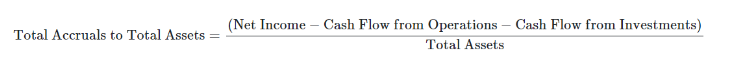

In [27]:
def calc_TATA(company):
    resList = {}
    for year in company['Profit Loss'].index:
        incs = company['Profit Loss'].loc[year]
        bs = company['Balance Sheet'].loc[year]
        cf = company['Cash Flow'].loc[year]
        
        if 'PreTax Profit' not in incs or 'Net Operating Cashflows' not in cf or 'Net Investing Cashflows' not in cf or 'Total Assets' not in bs:
            resList[year] = np.nan
            continue

        res = incs['PreTax Profit'] - cf['Net Operating Cashflows'] - cf['Net Investing Cashflows']
        res = res / bs['Total Assets']
        resList[year] = res

    return pd.Series(resList)

#### The TATA looks at non-cash earnings and indicates that a higher positive accruals means higher likelihood of earnings manipulation. On this line plot of ADH there are high raises in the year 2016 and 2020.

<AxesSubplot:>

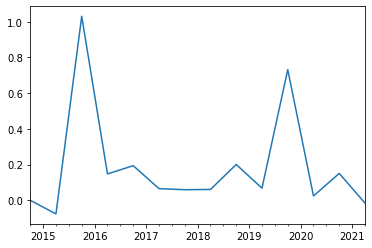

In [28]:
calc_TATA(workbooks_combined['ADH']).plot()

#### This graph indicates that the variance in the data between the different companies is quite high and it can be noted that the more erratic TATA would have a larger impact on the m-score output.

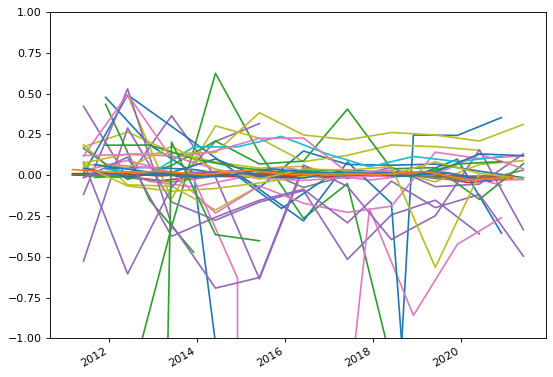

In [29]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.set_ylim(-1, 1)

for workbook in workbooks_separated:
    for period in workbooks_separated[workbook]:
        res = calc_TATA(workbooks_separated[workbook][period])
        res.plot(ax=ax)


### 8. LVGI

#### The Leverage Index is a ratio based on the current period(lev1) Leverage and the prior period Leverage(lev0). To compute the Leverage ‘NCL - Long-Term Debt’, ‘Total Current Liabilities’  and ‘Total Assets’ from the Balance Sheet of each company is required. 

The following formula was used to calculate LVGI:

            Leverage = (Long term debt + current liabilities) / Total assets 

In [30]:
def calc_LVGI(company):
    res = {}
    bs = company['Balance Sheet']
    for row in range(0, len(bs)):
        if 'NCL - Long-Term Debt' not in bs or 'Total Curr. Liabilities' not in bs or 'Total Assets' not in bs:
            res[bs.index[row]] = np.nan
            continue
            
        if row - 1 < 0:
            res[bs.index[row]] = np.nan
            continue      
            
        t1 = bs.iloc[row]
        t0 = bs.iloc[row-1]
        
        lev1 = t1['NCL - Long-Term Debt'] + t1['Total Curr. Liabilities']
        lev1 = lev1 / t1['Total Assets']
        
        lev0 = t0['NCL - Long-Term Debt'] + t0['Total Curr. Liabilities']
        lev0 = lev0 / t0['Total Assets']
                
        res[bs.index[row]] = lev1/lev0
        
    return pd.Series(res)

#### Using the BCI (BCI Minerals Ltd) financial data, there are various high peaks which indicate higher the leverage ratio,which means the higher the possibility of the company being involved in financial fraud.

<AxesSubplot:>

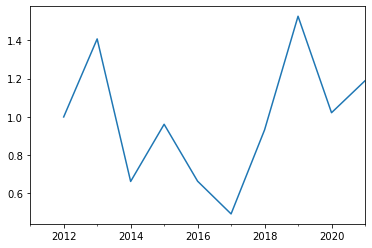

In [31]:
calc_LVGI(workbooks_separated['BCI']['FY']).plot()

### M-Score

#### This function calculates the M-Score using the ratio calculation functions described above. The weightings for each factor are fixed as seen below.

In [32]:
# Same as calc_mscore, except returns each m-score weighted factor for each period
def calc_mscore_factors(company_name):
    res = {}
    
    # DSRI is calculated using the separated dataset which appears to be less prone to null values / extreme outliers
    dsriFY = pd.DataFrame(calc_DSRI(workbooks_separated[company_name]['FY']))
    dsriHY = pd.DataFrame(calc_DSRI(workbooks_separated[company_name]['HY']))
    dsri = dsriFY.append(dsriHY, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(0)
    dsri = pd.Series(dsri[0])
    
    # GMI is calculated with the combined dataset
    gmi = calc_GMI(workbooks_combined[company_name]).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # AQI is only calculated from FY data as the datasets consistently emit HY asset data
    aqi1 = pd.DataFrame(calc_AQI(workbooks_separated[company_name]['FY']))
    aqi2 = pd.DataFrame(calc_AQI(workbooks_separated[company_name]['HY'])) # Use this to grab the dates, values will be empty
    aqi = aqi1.append(aqi2, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(1)
    aqi = pd.Series(aqi[0])

    # SGI is calculated using the separated dataset since revenue for the FY period includes the HY revenue as well, meaning 
    # that comparisons are more useful from HY to HY and FY to FY    
    sgiFY = pd.DataFrame(calc_SGI(workbooks_separated[company_name]['FY']))
    sgiHY = pd.DataFrame(calc_SGI(workbooks_separated[company_name]['HY']))
    sgi = sgiFY.append(sgiHY, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(0)
    sgi = pd.Series(sgi[0])
    
    # DEPI is calculated using the separated dataset since depreciation for the FY period includes the HY depreciation as well, 
    # meaning that comparisons are more useful from HY to HY and FY to FY    
    depiFY = pd.DataFrame(calc_DEPI(workbooks_separated[company_name]['FY']))
    depiHY = pd.DataFrame(calc_DEPI(workbooks_separated[company_name]['HY']))
    depi = depiFY.append(depiHY, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(1)
    depi = pd.Series(depi[0])
    
    # SGAI is calculated with the combined dataset
    sgai = calc_SGAI(workbooks_combined[company_name]).replace([np.inf, -np.inf], np.nan).fillna(1)
    
    # TATA is only calculated from FY data as the datasets consistently emit HY asset data
    tata1 = pd.DataFrame(calc_TATA(workbooks_separated[company_name]['FY']))
    tata2 = pd.DataFrame(calc_TATA(workbooks_separated[company_name]['HY'])) # Use this to grab the dates, values will be empty
    tata  = tata1.append(tata2, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
    tata = pd.Series(tata[0])

    # LVGI is only calculated from FY data as the datasets consistently emit HY leverage data
    lvgi1 = pd.DataFrame(calc_LVGI(workbooks_separated[company_name]['FY']))
    lvgi2 = pd.DataFrame(calc_LVGI(workbooks_separated[company_name]['HY'])) # Use this to grab the dates, values will be empty
    lvgi  = lvgi1.append(lvgi2, sort=True).sort_index().replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
    lvgi = pd.Series(lvgi[0])
    
    if len(dsri) == 0:
        dsri = pd.Series(tata)
        dsri[0] = 0
    if len(gmi) == 0:
        gmi = pd.Series(tata)
        gmi[0] = 0
    if len(sgi) == 0:
        sgi = pd.Series(tata)
        sgi[0] = 0
    
    for date in reversed(tata.index):
        mscore_factors = {}

        mscore_factors['DSRI'] = 0.92*dsri.loc[date]
        mscore_factors['GMI'] = 0.528*gmi.loc[date]
        mscore_factors['AQI'] = 0.404*aqi.loc[date]
        mscore_factors['SGI'] = 0.892*sgi.loc[date]
        mscore_factors['DEPI'] = 0.115*depi.loc[date]
        mscore_factors['SGAI'] = -0.172*sgai.loc[date]
        mscore_factors['TATA'] = 4.679*tata.loc[date]
        mscore_factors['LVGI'] = -0.327*lvgi.loc[date]
        
        res[date] = mscore_factors
        
    res = pd.DataFrame(res)
    
    mscore_total = res.sum(axis=0) - 4.84
    res.loc['M-Score'] = mscore_total
    res.loc['M-Score TF'] = mscore_total > -1.78
    res.loc['M-Score TF'] = res.loc['M-Score TF'].astype(bool)

    return res.transpose()

#### Here the M-Scores for ADH are calculated. The scores range from approximately -6.5 to 5.8. Note that any value over -1.78 is considered to be anomalous, therefore the reporting periods of 2016-12-01 and 2019-12-01 are of particular interest. The 2016 period coincides with the penalty notice issued to ADH as a result of materially understating their forecasted earnings, which resulted in them being issued a fine by ASIC.

In [33]:
ADH_factors = calc_mscore_factors('ADH')
ADH_factors

<ipython-input-15-1de882bebd76>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-15-1de882bebd76>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-25-074f2654ca65>:21: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']


,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI,M-Score,M-Score TF
2021-06-01,0.00,0.76,0.38,0.69,0.09,-0.19,-0.07,-0.36,-3.55,False
2020-12-01,0.55,0.28,0.36,0.66,0.08,-0.15,0.11,-0.49,-3.43,False
2020-06-01,0.00,0.38,0.36,0.79,0.10,-0.16,0.11,-0.49,-3.75,False
2019-12-01,2.56,0.62,0.38,0.81,0.16,-0.16,0.32,-0.37,-0.51,True
2019-06-01,0.00,0.56,0.38,0.81,0.10,-0.17,0.32,-0.37,-3.21,False
2018-12-01,0.06,0.56,0.40,0.81,0.10,-0.17,0.28,-0.26,-3.06,False
2018-06-01,0.00,0.51,0.40,0.75,0.10,-0.17,0.28,-0.26,-3.23,False
2017-12-01,0.89,0.45,0.40,0.75,0.09,-0.17,0.31,-0.31,-2.43,False
2017-06-01,0.00,0.46,0.40,0.85,0.14,-0.17,0.31,-0.31,-3.16,False
2016-12-01,0.97,0.82,0.37,0.84,0.16,-0.19,0.69,-0.28,-1.45,True


<AxesSubplot:>

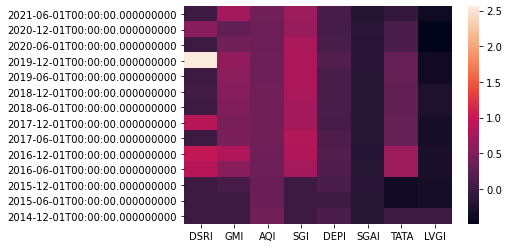

In [34]:
sns.heatmap(ADH_factors[ADH_factors.columns[:-2]].astype('float'))

#### Here the M-Score factors for ADH's two anomalous periods (2016-12-01 and 2019-12-01) are compared to the most recent period which is not anomalous. Higher values indicate a higher contribution to the M-score, thus a higher degree of abnormality

<AxesSubplot:>

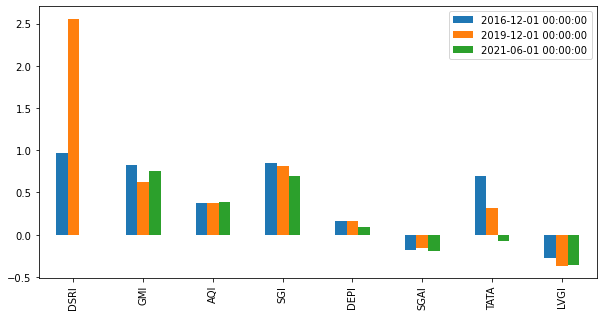

In [35]:
anomalies = ADH_factors.transpose()[:-2][[datetime.datetime(2016,12,1), datetime.datetime(2019,12,1), datetime.datetime(2021,6,1)]]
anomalies.plot.bar(figsize=(10, 5))

#### Here the M-Scores for each company are calculated and plotted. It's evident that there are a few extreme outliers which may indicate exceptionally anomalous reporting periods.

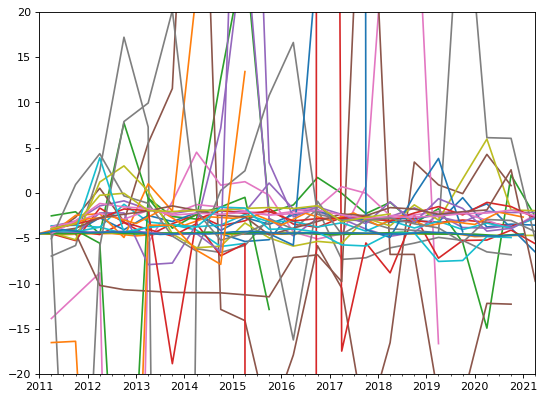

In [36]:
import warnings

with warnings.catch_warnings(record=True):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    ax.set_ylim(-20, 20)

    for company in workbooks_combined:
        res = calc_mscore_factors(company)
        res['M-Score'].plot(ax=ax)  


#### Here the M-Scores for each company's reporting periods are stored for later reference

In [37]:
import warnings

mscores = {}

with warnings.catch_warnings(record=True):
    for company in workbooks_combined:
        mscore_factors = calc_mscore_factors(company)
        workbooks_combined[company]['Penalty Notices'] = mscore_factors

In [38]:
workbooks_combined['ADH']['Penalty Notices']

,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI,M-Score,M-Score TF
2021-06-01,0.00,0.76,0.38,0.69,0.09,-0.19,-0.07,-0.36,-3.55,False
2020-12-01,0.55,0.28,0.36,0.66,0.08,-0.15,0.11,-0.49,-3.43,False
2020-06-01,0.00,0.38,0.36,0.79,0.10,-0.16,0.11,-0.49,-3.75,False
2019-12-01,2.56,0.62,0.38,0.81,0.16,-0.16,0.32,-0.37,-0.51,True
2019-06-01,0.00,0.56,0.38,0.81,0.10,-0.17,0.32,-0.37,-3.21,False
2018-12-01,0.06,0.56,0.40,0.81,0.10,-0.17,0.28,-0.26,-3.06,False
2018-06-01,0.00,0.51,0.40,0.75,0.10,-0.17,0.28,-0.26,-3.23,False
2017-12-01,0.89,0.45,0.40,0.75,0.09,-0.17,0.31,-0.31,-2.43,False
2017-06-01,0.00,0.46,0.40,0.85,0.14,-0.17,0.31,-0.31,-3.16,False
2016-12-01,0.97,0.82,0.37,0.84,0.16,-0.19,0.69,-0.28,-1.45,True


### Penalty Notices

#### Here we derive a dataset that attempts to capture the periods in which fraud or malicious activity occurred by each company, using the dates of the issues within the penalty notices issued by ASIC as a proxy. 

In [39]:
penalty_notices = pd.read_excel('COMP3850 Penalty Dates.xlsx', sheet_name=None)
penalty_notices = pd.DataFrame(penalty_notices['Sheet1'])
penalty_notices

,ADH,ANZ,BCI,BFG,BHP,BNL,BPG,BTR,CBA,CCC,...,NAB,NCM,NGI,REX,RIO,RNO,SRX,SRZ,WBC,WCC
0,2016-09-23,2020-10-01,2012-03-01,2015-07-14,2012-03-05,2015-09-07,2017-12-14,2013-06-17,2014-12-01,2017-02-26,...,2012-09-08,2011-03-30,2020-09-21,2020-05-11,2012-03-05,2014-06-06,2016-12-09,2013-06-03,2013-10-02,2014-07-16


#### Calculating penalty dates that correpond with reporting periods

In [40]:
for company in workbooks_combined:
    dates = workbooks_combined[company]['Profit Loss'].index
    dates = pd.DataFrame(index=dates)
    dates['Penalty Issued'] = False
    workbooks_combined[company]['Penalty Notices']['Penalty Issued'] = dates
    
    for penalty_date in penalty_notices[company]:
        for date in dates.index:
            time_delta = ((penalty_date - date)/np.timedelta64(1, 'M'))

            if time_delta < 0 and time_delta > -6:
                dates.loc[date] = True
    
    workbooks_combined[company]['Penalty Notices']['Penalty Issued'] = dates

### Confusion Matrix

In [41]:
workbooks_combined['ADH']['Penalty Notices']

,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI,M-Score,M-Score TF,Penalty Issued
2021-06-01,0.00,0.76,0.38,0.69,0.09,-0.19,-0.07,-0.36,-3.55,False,False
2020-12-01,0.55,0.28,0.36,0.66,0.08,-0.15,0.11,-0.49,-3.43,False,False
2020-06-01,0.00,0.38,0.36,0.79,0.10,-0.16,0.11,-0.49,-3.75,False,False
2019-12-01,2.56,0.62,0.38,0.81,0.16,-0.16,0.32,-0.37,-0.51,True,False
2019-06-01,0.00,0.56,0.38,0.81,0.10,-0.17,0.32,-0.37,-3.21,False,False
2018-12-01,0.06,0.56,0.40,0.81,0.10,-0.17,0.28,-0.26,-3.06,False,False
2018-06-01,0.00,0.51,0.40,0.75,0.10,-0.17,0.28,-0.26,-3.23,False,False
2017-12-01,0.89,0.45,0.40,0.75,0.09,-0.17,0.31,-0.31,-2.43,False,False
2017-06-01,0.00,0.46,0.40,0.85,0.14,-0.17,0.31,-0.31,-3.16,False,False
2016-12-01,0.97,0.82,0.37,0.84,0.16,-0.19,0.69,-0.28,-1.45,True,True


#### From the predictions below, we've identified that the model successfully detected 15 out of 28 (53.6%) anomalous periods based on the in-scope penalty notices, and missed 13 of them. The model confirmed a considerable proportion of the true negative periods, i.e. the periods which were not anomalous (347 out of 557 or 62.3%). Interestingly, the model flagged 210 periods as anomalous that did not appear in the ground truth dataset derived from the penalty notices. This could be an indicator that there were anomalous events during these periods that were missed by ASIC and could correspond with undetected suspicious activity. Alternatively, this could indicate that the model was too ambitious in detecting anomalies

In [42]:
TP = 0
TN = 0
FP = 0
FN = 0

for company in workbooks_combined:
    company_penalties = workbooks_combined[company]['Penalty Notices']
    for [actual, predicted] in zip(company_penalties['Penalty Issued'], company_penalties['M-Score TF']):
        if actual == True:
            if predicted == True:
                TP += 1
                print(company, 'Correctly predicted')
            else:
                FN += 1
                print(company, 'Missed')
        if actual == False:
            if predicted == False:
                TN += 1
            else:
                FP += 1 

print('True Positives', TP)
print('True Negatives', TN)
print('False Positives', FP)
print('False Negatives', FN)

                

ADH Correctly predicted
ANZ Missed
BCI Missed
BFG Correctly predicted
BHP Correctly predicted
BNL Missed
BPG Correctly predicted
BTR Missed
CBA Missed
CIM Missed
CVR Correctly predicted
DGX Missed
DTZ Correctly predicted
GMN Missed
HWK Missed
JBH Missed
LCT Correctly predicted
MEB Missed
MFG Missed
MGC Missed
MQG Missed
NAB Missed
NCM Missed
NGI Missed
REX Missed
RIO Correctly predicted
RNO Missed
SRX Missed
SRZ Missed
WBC Missed
WCC Missed
True Positives 8
True Negatives 454
False Positives 100
False Negatives 23


In [43]:
workbooks_combined['ANZ']['Penalty Notices']

,DSRI,GMI,AQI,SGI,DEPI,SGAI,TATA,LVGI,M-Score,M-Score TF,Penalty Issued
2021-03-01,-0.02,-0.01,0.40,-0.02,0.12,-0.17,-0.11,-0.00,-4.66,False,True
2020-09-01,-0.03,-0.02,0.40,-0.03,0.12,-0.17,-0.15,-0.00,-4.72,False,False
2020-03-01,-0.04,-0.02,0.40,-0.04,0.12,-0.17,-0.21,-0.00,-4.81,False,False
2019-09-01,0.01,0.01,0.40,0.01,0.12,-0.17,0.06,-0.00,-4.40,False,False
2019-03-01,-0.00,-0.00,0.40,-0.00,0.12,-0.17,-0.01,-0.00,-4.50,False,False
2018-09-01,0.00,0.00,0.40,0.00,0.12,-0.17,0.00,-0.00,-4.49,False,False
2018-03-01,-0.01,-0.00,0.40,-0.01,0.12,-0.17,-0.03,-0.00,-4.53,False,False
2017-09-01,-0.00,-0.00,0.40,-0.00,0.12,-0.17,-0.01,-0.00,-4.51,False,False
2017-03-01,-0.01,-0.00,0.40,-0.01,0.12,-0.17,-0.04,-0.00,-4.56,False,False
2016-09-01,0.01,0.01,0.40,0.01,0.12,-0.17,0.06,-0.00,-4.40,False,False


### New regression of m-score factors

#### Here we construct a new set of weightings of the m-score factors based on a logistic regression against the Penalty Issued indicator for each reporting period

In [44]:
df_regression = pd.DataFrame()

with warnings.catch_warnings(record=True):
    for company in workbooks_combined:
        t = calc_mscore_factors(company)
        t['Penalty Issued'] = workbooks_combined[company]['Penalty Notices']['Penalty Issued']
        df_regression = df_regression.append(t)
    


In [45]:
logisticRegr = LogisticRegression()

X = df_regression[['DSRI','GMI', 'AQI', 'SGI', 'DEPI', 'SGAI', 'TATA', 'LVGI']] 
transformer = RobustScaler().fit(X)
X = transformer.transform(X)

Y = df_regression[['Penalty Issued']] 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

logisticRegr.fit(X_train, y_train.values.ravel())
y_pred = logisticRegr.predict(X_test)

score = logisticRegr.score(X_test, y_test)
print(logisticRegr.coef_, score)

[[-1.92467315e-01 -4.83848521e-03  1.03891046e-03 -5.32844410e-04
  -4.50951952e-03  1.03740590e-04  3.74830748e-02 -2.65325929e-01]] 0.9322033898305084


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


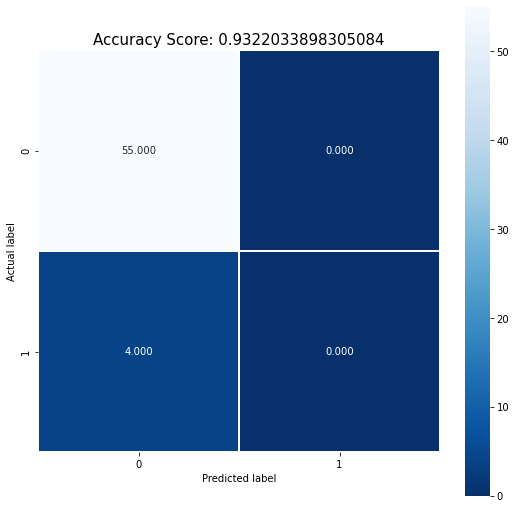

In [46]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [47]:
regr = MLPRegressor(random_state=1, max_iter=500)

X = df_regression[['DSRI','GMI', 'AQI', 'SGI', 'DEPI', 'SGAI', 'TATA', 'LVGI']] 
transformer = RobustScaler().fit(X)
X = transformer.transform(X)

Y = df_regression[['Penalty Issued']] 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

regr.fit(X_train, y_train.values.ravel())
y_pred = regr.predict(X_test)

score = regr.score(X_test, y_test)
print(score)

-46.40654207576636


### User Interface

#### Here we provide a simple method for users to obtain a result for a particular company

In [48]:
def get_result(company):
    anomalous_periods = pd.DataFrame()
    factors = calc_mscore_factors(company)

    for date in workbooks_combined[company]['Penalty Notices'].index:
        if workbooks_combined[company]['Penalty Notices'].loc[date]['M-Score TF']:
            anomalous_periods[date] = workbooks_combined[company]['Penalty Notices'].loc[date]

            
    if len(anomalous_periods.index) > 0:
        anomalous_periods[:-3].plot.bar(figsize=(10, 8))
    else:
        print("No anomalies found")

<ipython-input-15-1de882bebd76>:10: RuntimeWarning: divide by zero encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-15-1de882bebd76>:10: RuntimeWarning: invalid value encountered in double_scalars
  res[days_receivables.index[row]] = t1/t0
<ipython-input-25-074f2654ca65>:21: RuntimeWarning: invalid value encountered in double_scalars
  sga0 = sga0 / t0['Total Revenue Excluding Interest']


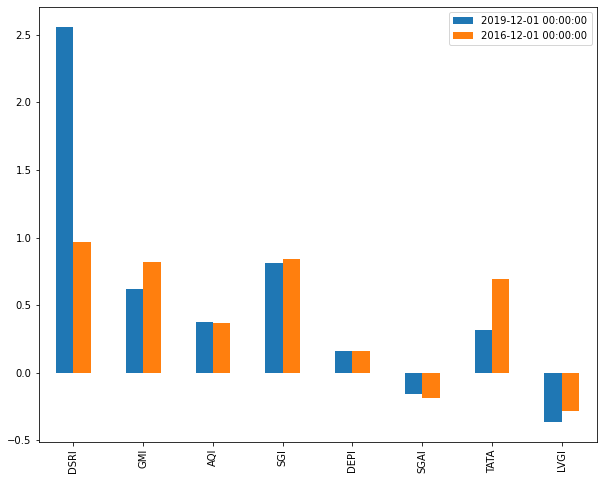

In [50]:
get_result('ADH')